# NYC MoMA Artworks - Collections In-take and Space-use Forecasting

## Table of Contents
<ol>
  <li><a href="#load-libraries">Load libraries</a></li>
  <li><a href="#data-process">Data Preprocessing</a></li>
  <li><a href="#ts-decomp">Overall Time Series Decomposition</a></li>
  <li><a href="#spatial">Spatial Time Series Analysis</a></li>
  <ol>
    <li><a href="#spatial-ts">Analysis of Space-use over Time</a></li>
  </ol>
  <li><a href="#ts-model-declare">Time Series Model Initialization</a></li>
  <li><a href="#ts-model">Time Series Model Comparisons</a></li>
  <ol>
    <li><a href="#ts-model-tv">Time Series Model Training & Validation</a></li>
    <li><a href="#ts-model-forecast">Time Series Forecasting Estimates</a></li>
  </ol>
  <li><a href="#conclusions">Conclusions</a></li>
  <li><a href="#recommendations">Recommendations</a></li>
</ol>

<section id="load-libraries">
    <h2>Load Libraries</h2>
</section>

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from darts import TimeSeries
from darts.models import (NaiveDrift, NaiveMovingAverage, ExponentialSmoothing, Croston,
                          CatBoostModel, RandomForest, NaiveEnsembleModel, LightGBMModel)
from darts.explainability.shap_explainer import ShapExplainer
from darts.utils.statistics import check_seasonality, stationarity_tests, plot_residuals_analysis, fill_missing_values
import darts.metrics as metrics
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import warnings

sns.set_palette("colorblind")
pd.set_option("display.float_format", "{:0.3f}".format)
warnings.filterwarnings("ignore")

C:\Users\lilyc\Desktop\human_docs\work\MMM\Museum Analytics Consulting\examples\NYC_MoMA_Example\nyc-moma-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define Necessary Functions
def remove_outliers(dataset, lower = 0.25, upper = 0.75):
    # Remove numerical outliers from the dataset
    dataset.astype(np.float64)
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)

    return dataset[(dataset > lower_outliers) & (dataset < upper_outliers)]


def gen_ts_features(df, date_column, more_columns):
    # Generates Time Series Features based on date_column
    # Makes for easier analysis of operational (day-to-day) processes.
    out = df[[date_column] + more_columns].copy()
    out[date_column] = pd.to_datetime(out[date_column], format = "%m/%d/%Y", errors = "coerce")
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    out["weekday"] = pd.Categorical(out[date_column].dt.day_name(), categories = weekday_order, ordered = True)
    out["day_of_month"] = out[date_column].dt.day.astype(int)
    out["day_of_year"] = out[date_column].dt.dayofyear.astype(int)
    out["week_of_month"] = (out[date_column].dt.day / 7).apply(lambda x: np.ceil(x)).astype(int)
    out["week"] = out[date_column].dt.isocalendar().week.astype(int)
    out["month"] = out[date_column].dt.month.astype(int)
    out["year"] = out[date_column].dt.isocalendar().year.astype(int)
    return out


def is_stationary(series):
    # Hypothesis Testing for Time Series data
    # Perform two separate stationarity tests
    result = stationarity_tests(series, p_value_threshold_adfuller=0.05, p_value_threshold_kpss=0.05)

    if result:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")
    return result


def has_seasonality(series):
    result = check_seasonality(series)

    if result[0]:
        print(f"The time series has seaonality, with a period of {result[1]}")
    else:
        print("The time series does not have seasonality.")
    return result

In [3]:
# Data Preprocessing
dataset = (pd.read_csv("NYC-MoMA-Recent-Collections_TS.csv", index_col=0)
.sort_values("acquisition_date")
.drop(columns =["acc_gaps"])
)
dataset.loc[:, "adate_sum"] = pd.to_numeric(dataset["adate_sum"], errors="coerce")
clean_dataset = (dataset.astype({
    "acquisition_date": "datetime64[ns]",
    # "date": "datetime64[ns]",
    "department": "category",
    "credit_group": "category",
    "storage_group": "category",
    # "day_of_month": "category",
    # "day_of_year": "category",
    # "week": "category",
    # "month": "category",
    # "year": "category",
    "weekday": "category",
    })
    .drop(columns = ["height_ft", "width_ft", "depth_ft", "cubic_ft", "spatial_running_total"]))
# clean_dataset["date"] = pd.Categorical(clean_dataset["date"].dt.strftime("%Y"))

# Merge exogenous columns back onto groupby
# adate_groupby = clean_dataset.groupby("acquisition_date").agg({"adate_sum": "sum", "date": lambda x: mode(x) if not mode(x) == "" else None, "weekday": lambda x: mode(x)[0] if not mode(x) == "" else None}).reset_index()
adate_groupby = (clean_dataset.set_index("acquisition_date").resample("D").agg({
    "adate_sum": "sum",
    "day_of_month": "mean",
    "day_of_year": "mean",
    "week": "mean",
    "month": "mean",
    "year": "mean",
    # "date": lambda x: x.mode()[0] if not x.mode().empty else None,
    "department": lambda x: x.mode()[0] if not x.mode().empty else None,
    "credit_group": lambda x: x.mode()[0] if not x.mode().empty else None,
    "storage_group": lambda x: x.mode()[0] if not x.mode().empty else None,
    "weekday": lambda x: x.mode()[0] if not x.mode().empty else None,
    # "day_of_month": "first",
    # "day_of_year": "first",
    # "week_of_month": "first",
    # "week": "first",
    # "month": "first",
    # "year": "first",
    # "weekday": lambda x: x.mode()[0] if not x.mode().empty else None,
}).reset_index())
# adate_groupby = adate_groupby.astype({"acquisition_date": "datetime64[ns]"})

adate_groupby = adate_groupby.astype({
    # "date": "category",
    "day_of_month": "float",
    "day_of_year": "float",
    "week": "float",
    "month": "float",
    "year": "float",
})

In [4]:
adate_groupby.dtypes

acquisition_date    datetime64[ns]
adate_sum                  float64
day_of_month               float64
day_of_year                float64
week                       float64
month                      float64
year                       float64
department                category
credit_group              category
storage_group             category
weekday                   category
dtype: object

In [5]:
total_nulls = adate_groupby.isna().sum()
total_nulls

acquisition_date       0
adate_sum              0
day_of_month        9979
day_of_year         9979
week                9979
month               9979
year                9979
department          9979
credit_group        9979
storage_group       9979
weekday             9979
dtype: int64

In [6]:
print("Total number of null records:", max(total_nulls))
print("Null record density (%):  {:0.3f}%".format(max(total_nulls) / adate_groupby.shape[0]))

Total number of null records: 9979
Null record density (%):  0.911%


In [7]:
# clean_dataset["acquisition_date"] = pd.DatetimeIndex(clean_dataset["acquisition_date"])
adate_groupby["acquisition_date"] = pd.DatetimeIndex(adate_groupby["acquisition_date"])
# dataset.index = dataset.set_index("acquisition_date")
# adate_groupby.index = adate_groupby.set_index("acquisition_date")
# dataset = dataset.drop(columns = ["acquisition_date"])
# adate_groupby = adate_groupby.drop(columns = ["acquisition_date"])

# merged = adate_groupby.merge(clean_dataset, on = ["acquisition_date", "adate_sum"], how = "outer")
# # merged = adate_groupby.merge(clean_dataset, on = ["date", "weekday", "adate_sum"], how = "outer")
# merged["adate_sum"] = merged["adate_sum"].fillna(0)
# clean_dataset["adate_sum"] = clean_dataset["adate_sum"].fillna(0)
# clean_dataset["date"] = clean_dataset["date"].fillna(clean_dataset["date"].mode()[0])

# Encode categorical columns as integers
label_encoders = defaultdict()
for column in ["department", "credit_group", "storage_group"]:
    le = LabelEncoder()
    adate_groupby[column] = le.fit_transform(adate_groupby[column])
    label_encoders[column] = le

oe = OrdinalEncoder()
adate_groupby["weekday"] = oe.fit_transform(np.array(adate_groupby["weekday"]).reshape(1, -1)).reshape(-1, 1)
label_encoders["weekday_ordinal"] = oe


for column in adate_groupby.columns.difference(["acquisition_date", "date"]):
    categorical_imputer = KNNImputer(n_neighbors = 7)
    adate_groupby.loc[:, column] = categorical_imputer.fit_transform(np.array(adate_groupby[column]).reshape(-1, 1))

# Adding lag features
lags = [1, 2, 3, 4, 5]  # Number of lags to create
for lag in lags:
    adate_groupby[f'adate_sum_lag_{lag}'] = adate_groupby['adate_sum'].shift(lag)

In [8]:
adate_groupby.isna().sum()

acquisition_date    0
adate_sum           0
day_of_month        0
day_of_year         0
week                0
month               0
year                0
department          0
credit_group        0
storage_group       0
weekday             0
adate_sum_lag_1     1
adate_sum_lag_2     2
adate_sum_lag_3     3
adate_sum_lag_4     4
adate_sum_lag_5     5
dtype: int64

In [9]:
# Dataset comparison - Record Loss
records = adate_groupby.shape[0]
final_dataset = adate_groupby.dropna().drop_duplicates("acquisition_date")
# final_dataset = final_dataset.drop(columns = ["weekday", "date"])
no_nulls = final_dataset.shape[0]

In [10]:
print("Number of Records before dropping nulls:", records)
print("Number of Records after dropping nulls:", no_nulls)
print("\n# of Records dropped: {:.2f}".format(np.abs(no_nulls - records)))
print("% of Records dropped: {:.2f}%".format((records - no_nulls) / (records)*100))

Number of Records before dropping nulls: 10956
Number of Records after dropping nulls: 10951

# of Records dropped: 5.00
% of Records dropped: 0.05%


In [11]:
# Non-count variables
exogenous_columns = [
    # "week_of_month",
    "day_of_month", "month", "weekday",
    "department", "credit_group", "storage_group", 
    "adate_sum_lag_1", "adate_sum_lag_2", "adate_sum_lag_3",
    "adate_sum_lag_4", "adate_sum_lag_5"
]
final_dataset["acquisition_date"] = pd.to_datetime(final_dataset["acquisition_date"])
exogenous_series = TimeSeries.from_dataframe(final_dataset, "acquisition_date", exogenous_columns, fill_missing_dates=True, freq="D")
target_series = TimeSeries.from_dataframe(final_dataset, "acquisition_date",  "adate_sum", fill_missing_dates=True, freq="D")

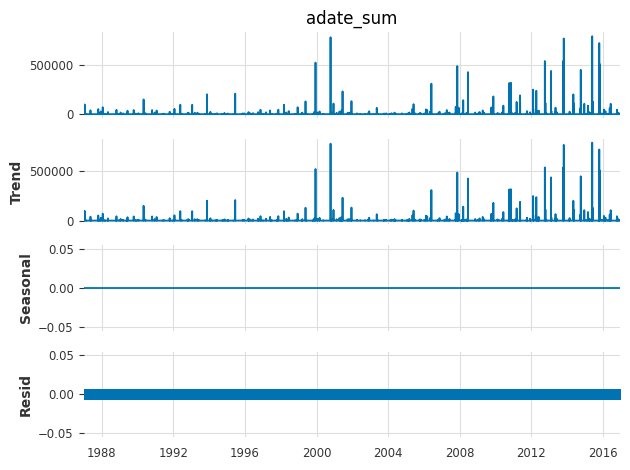

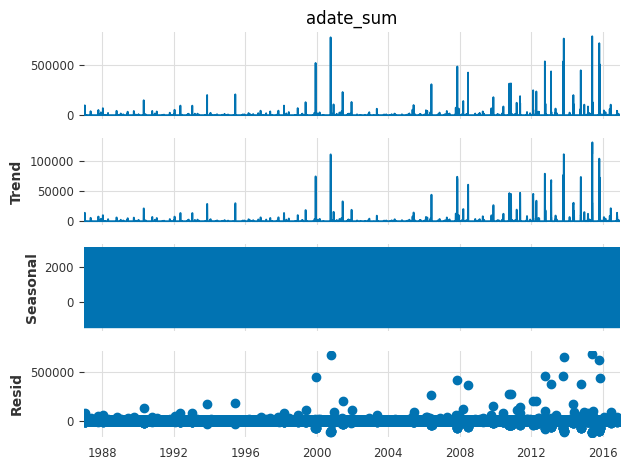

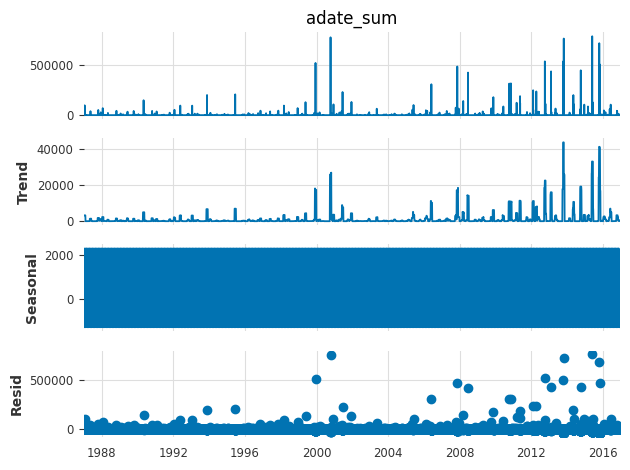

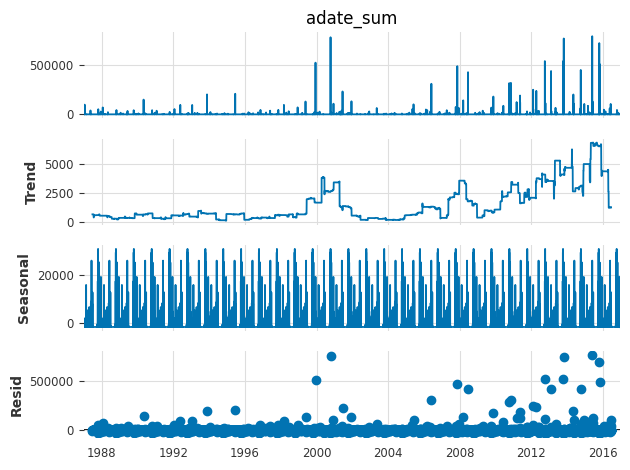

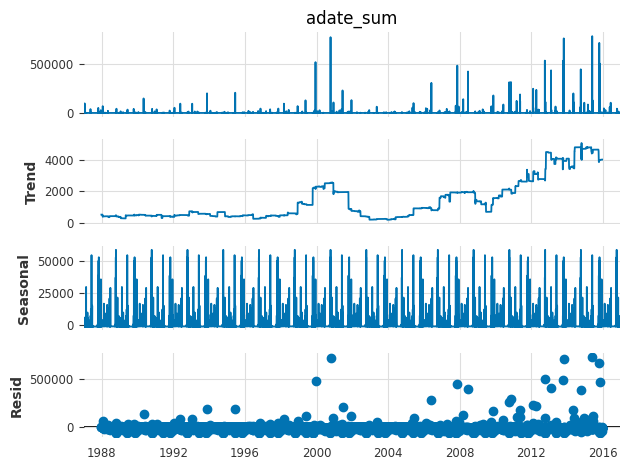

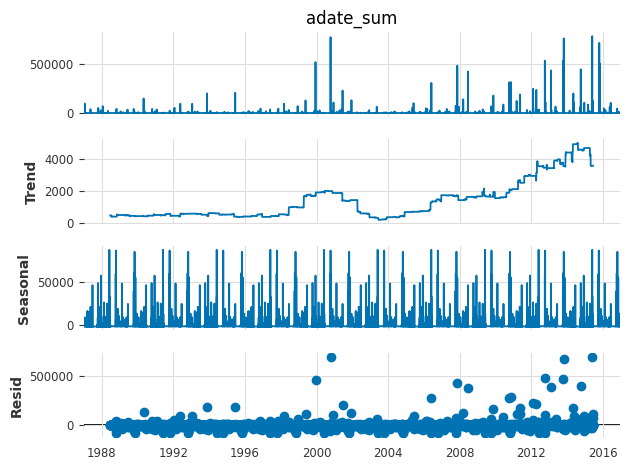

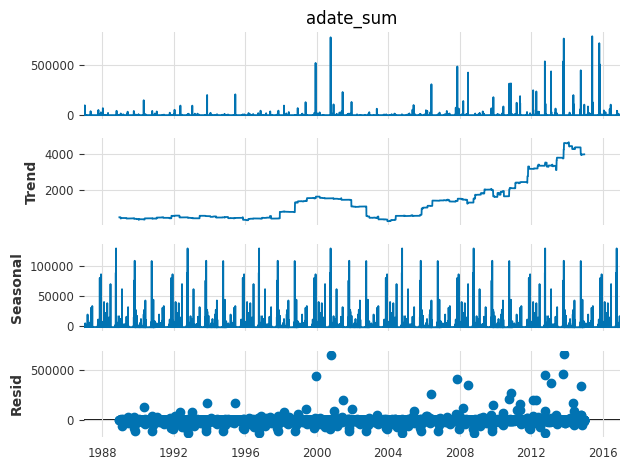

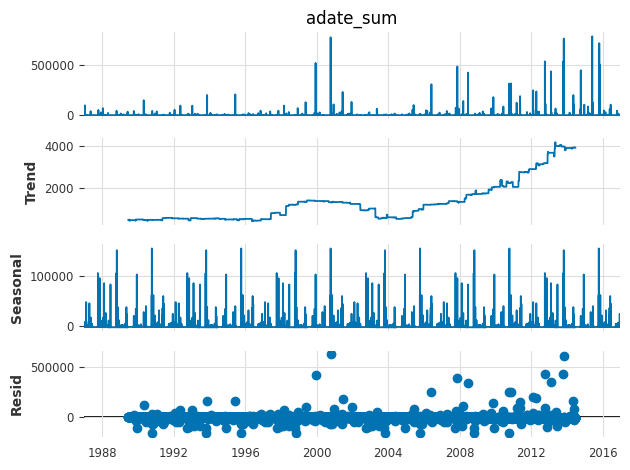

In [12]:
# Overall TS Decomposition
for days in [1, 7, 30, 365, (365 * 2), (365 * 3), (365 * 4), (365 * 5)]:  # Plotting against daily observations with daily, weekly, monthly, annual and bi-annual seasonality respectively.
    ts_data = final_dataset.set_index("acquisition_date").sort_index()["adate_sum"]
    decomp = sm.tsa.seasonal_decompose(ts_data, period = days)
    decomp.plot();

In [13]:
# Time Series Model Comparison Setup
lags = [-1, -2, -3, -4, -5]

# Statistical and Machine Learning Models with gentle tuning
models = {
    # Baseline Statistical Models
    "Naive Forecast": NaiveDrift(),
    "7-day Moving Average": NaiveMovingAverage(7),  # Naive Weekly Moving Average
    "14-day Moving Average": NaiveMovingAverage(14),  # Naive Biweekly Moving Average
    "30-day Moving Average": NaiveMovingAverage(30),  # Naive Monthly Moving Average
    "1/2-Year Moving Average": NaiveMovingAverage((365//2)),  # Naive Half-Year Moving Average
    "1-Year Moving Average": NaiveMovingAverage(365),  # Naive Yearly Moving Average
    "1-Year Moving Average": NaiveMovingAverage(365 * 3),  # Naive 3-Year Moving Average
    "Exponential Smoothing": ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10), # +1
    
    # Domain Specific Models - Intermittent Demand Forecasting
    "CROSTON Method": Croston(version = "optimized"),  # Modern Implementation of CROSTON
    "SBA": Croston(version = "sba"), # Syntetos-Boylan Approximation
    "TSB": Croston(version = "tsb", alpha_d = 0.1, alpha_p = 0.1), # Teunter-Syntetos-Babai

    # Multivariate ML models - Explainability metrics available
    "Decision Tree": RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = 5,
                                  random_state = 10, n_estimators = 1),  # +1
    "Random Forest (10)": RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = 5,
                                  random_state = 10, n_estimators = 10),  # +1
    "Random Forest (50)": RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = 5,
                                  random_state = 10, n_estimators = 50),  # +1  
    "Random Forest (100)": RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = 5,
                                  random_state = 10, n_estimators = 100),
    "Random Forest (200)": RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = 5,
                                  random_state = 10, n_estimators = 200),
    "LightGBM": LightGBMModel(lags = lags, output_chunk_length = 10, lags_past_covariates = 5,
                              random_state = 10, n_estimators=350, learning_rate = 0.05, verbose = 0),
    "CatBoost": CatBoostModel(lags = lags, output_chunk_length = 10, lags_past_covariates = 5,
                              random_state = 10, n_estimators=350, learning_rate = 0.05,
                              early_stopping_rounds = 300, task_type = "CPU"),  # +1
    
    # Ensemble method - Best of multiple ML approaches
    "Naive Ensemble (DT + RF(10))": NaiveEnsembleModel([
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = 5,
                     random_state = 10, n_estimators = 1),
        RandomForest(lags = lags, output_chunk_length = 10, lags_past_covariates = 5,
                     random_state = 10, n_estimators = 10),
    ]),
    "Naive Ensemble (ES + DT)": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10,
                     random_state = 10, n_estimators = 1),
    ]),
    "Naive Ensemble (ES + RF(2))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10,
                     random_state = 10, n_estimators = 2),
    ]),
    "Naive Ensemble (ES + RF(5))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10,
                     random_state = 10, n_estimators = 5),
    ]),
    "Naive Ensemble (ES + RF(10))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10,
                     random_state = 10, n_estimators = 10),
    ]),
    "Naive Ensemble (ES + RF(50))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10,
                     random_state = 10, n_estimators = 50),
    ]),
    "Naive Ensemble (ES + RF(100))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10,
                     random_state = 10, n_estimators = 100),
    ]),
    "Naive Ensemble (ES + RF(200))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        RandomForest(lags = lags, output_chunk_length = 10, 
                     random_state = 10, n_estimators = 200),
    ]),
    "Naive Ensemble (ES + CatBoost(300))": NaiveEnsembleModel([
        ExponentialSmoothing(seasonal_periods = (365 * 3), random_state = 10),
        CatBoostModel(lags = lags, output_chunk_length = 10, 
                      random_state = 10, n_estimators=300, learning_rate = 0.05),
    ])
}

In [14]:
date_offset = clean_dataset["acquisition_date"].max() - pd.DateOffset(years = 10)

print(f"Training using data from before: {date_offset}")
print(f"and after: {clean_dataset['acquisition_date'].min()}")

Training using data from before: 2006-12-15 00:00:00
and after: 1986-12-18 00:00:00


Successfully stored model [Naive Forecast] and its results.


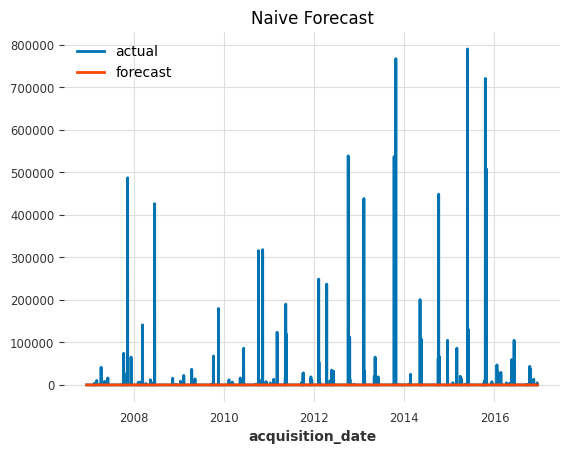

Successfully stored model [7-day Moving Average] and its results.


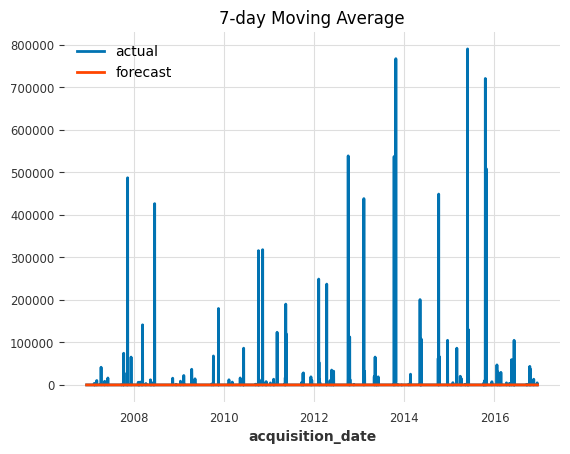

Successfully stored model [14-day Moving Average] and its results.


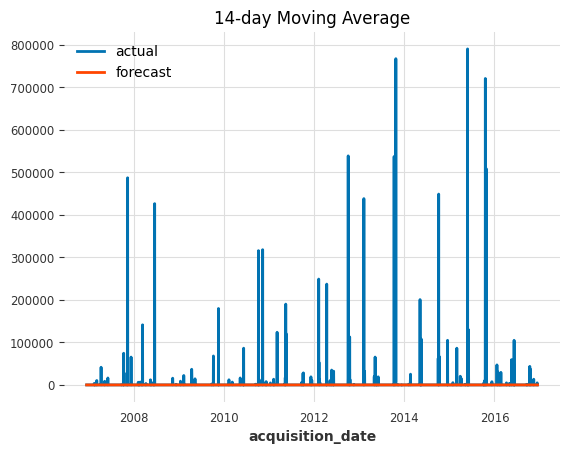

Successfully stored model [30-day Moving Average] and its results.


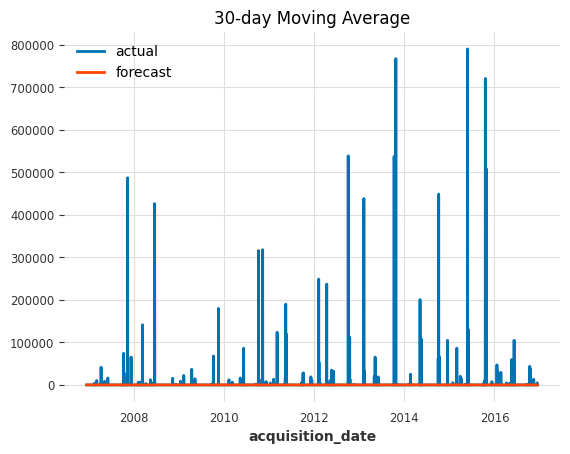

Successfully stored model [1/2-Year Moving Average] and its results.


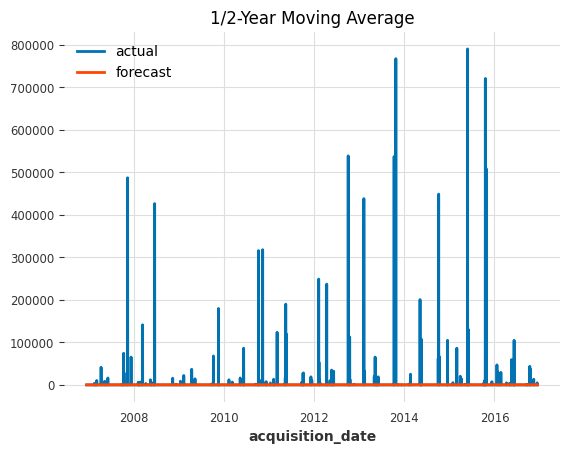

Successfully stored model [1-Year Moving Average] and its results.


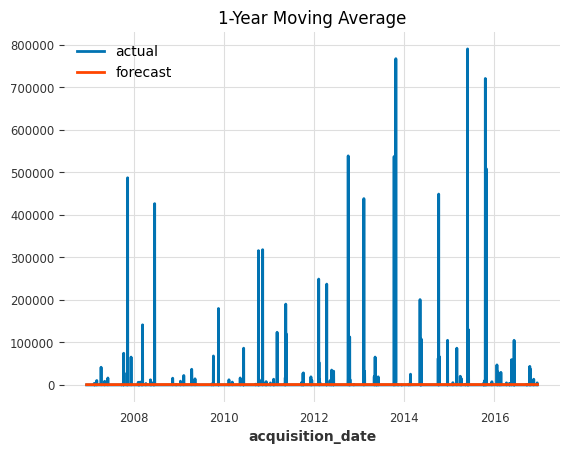

Successfully stored model [Exponential Smoothing] and its results.


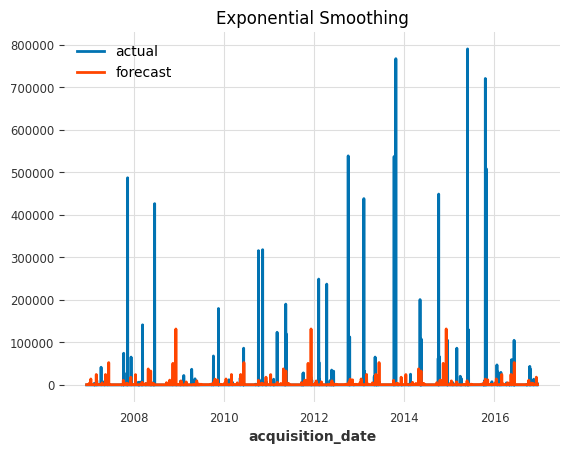

Successfully stored model [CROSTON Method] and its results.


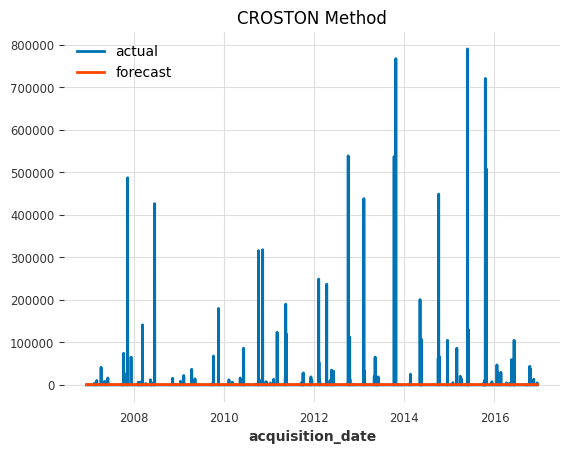

Successfully stored model [SBA] and its results.


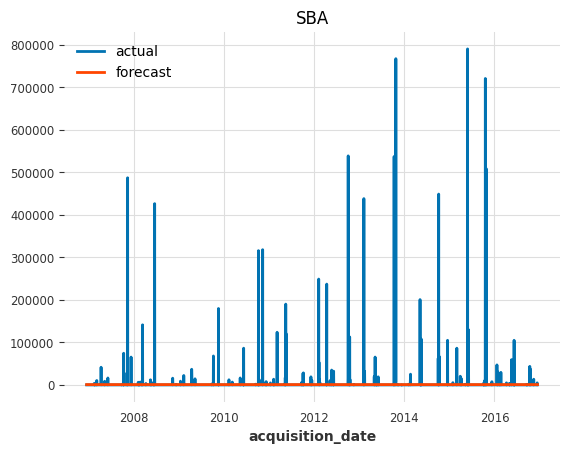

Successfully stored model [TSB] and its results.


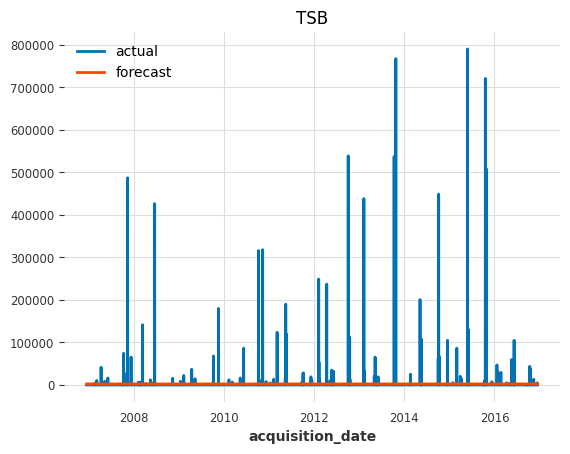

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Decision Tree] and its results.


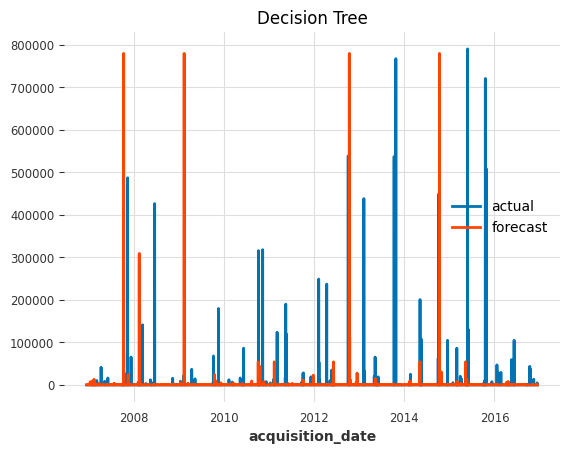

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Random Forest (10)] and its results.


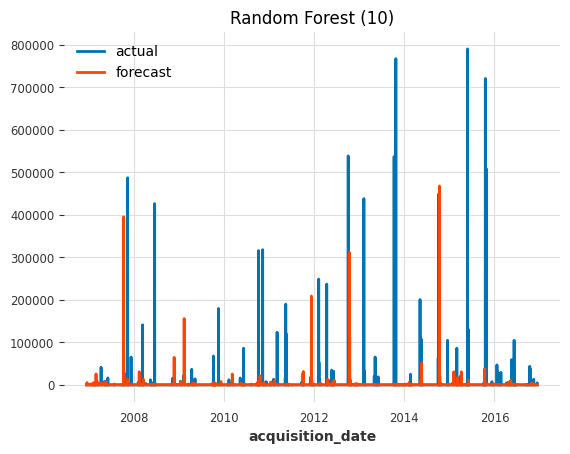

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Random Forest (50)] and its results.


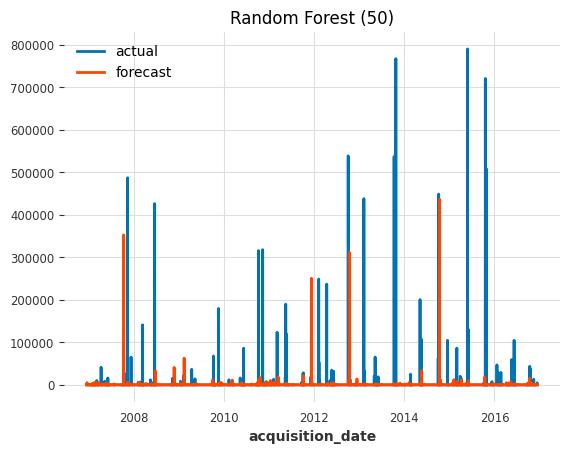

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Random Forest (100)] and its results.


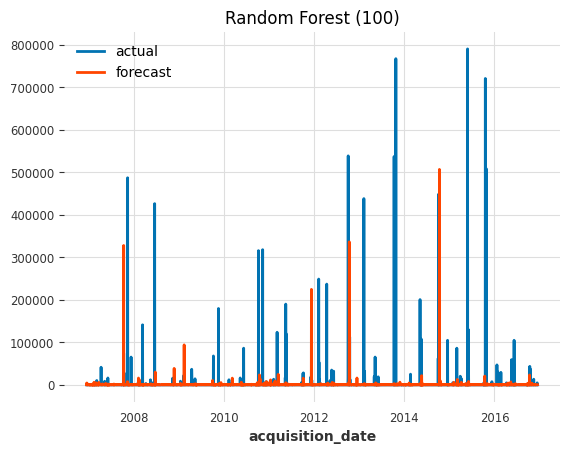

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Random Forest (200)] and its results.


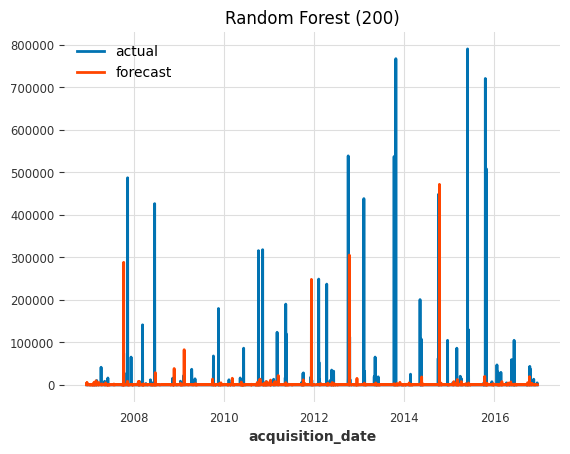

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [LightGBM] and its results.


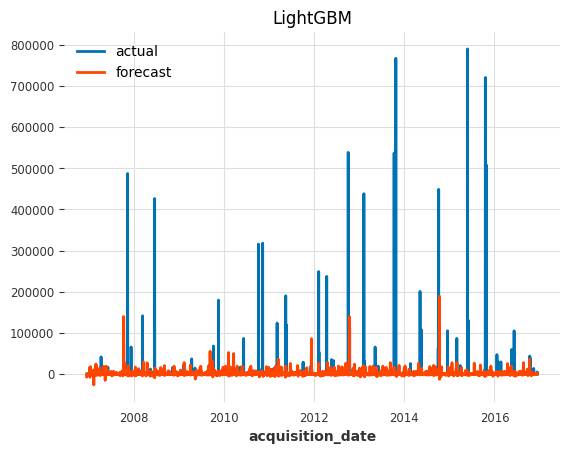

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [CatBoost] and its results.


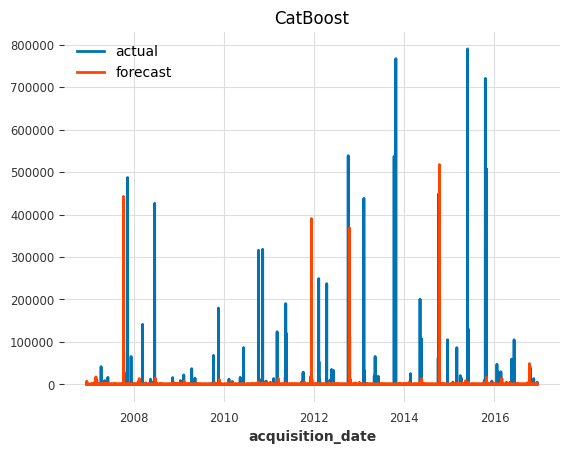

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Successfully stored model [Naive Ensemble (DT + RF(10))] and its results.


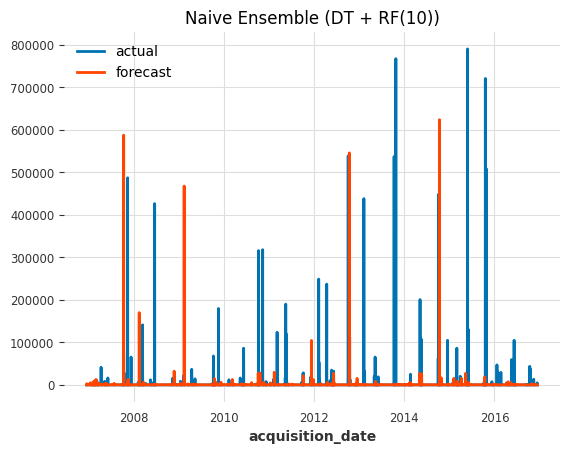

Successfully stored model [Naive Ensemble (ES + DT)] and its results.


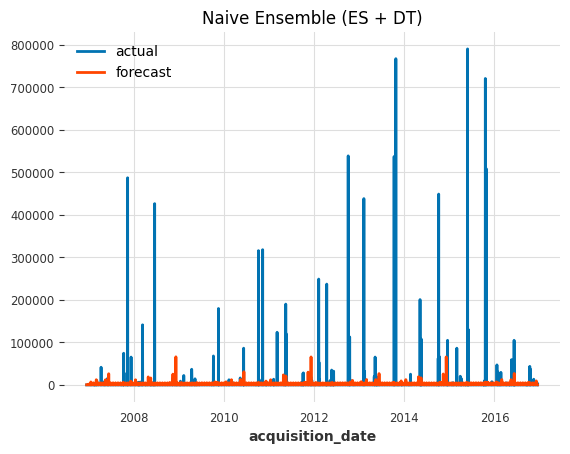

Successfully stored model [Naive Ensemble (ES + RF(2))] and its results.


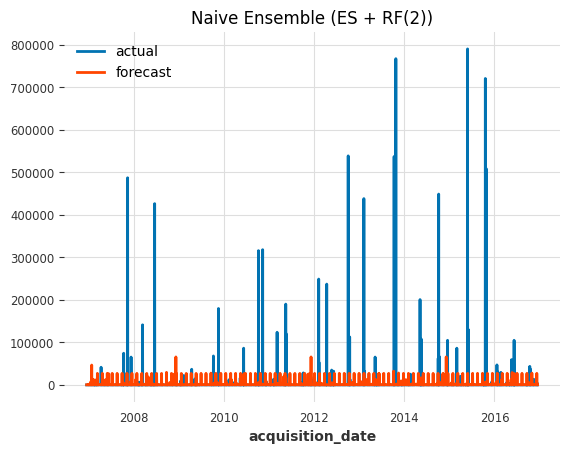

Successfully stored model [Naive Ensemble (ES + RF(5))] and its results.


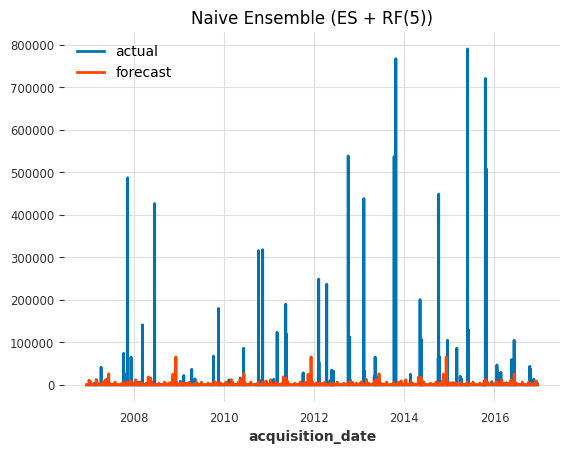

Successfully stored model [Naive Ensemble (ES + RF(10))] and its results.


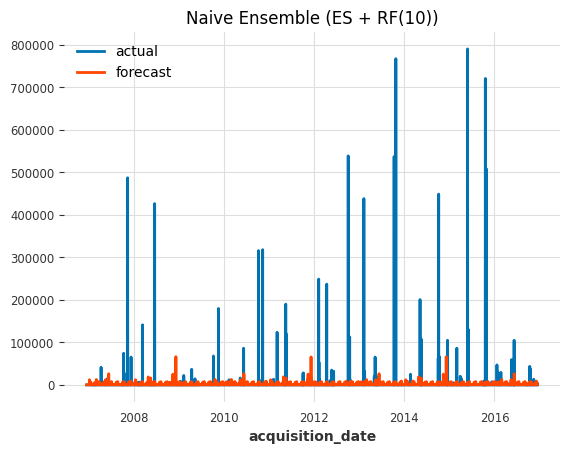

Successfully stored model [Naive Ensemble (ES + RF(50))] and its results.


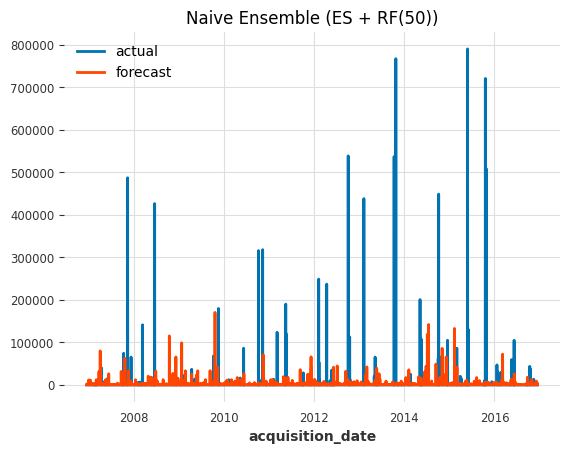

Successfully stored model [Naive Ensemble (ES + RF(100))] and its results.


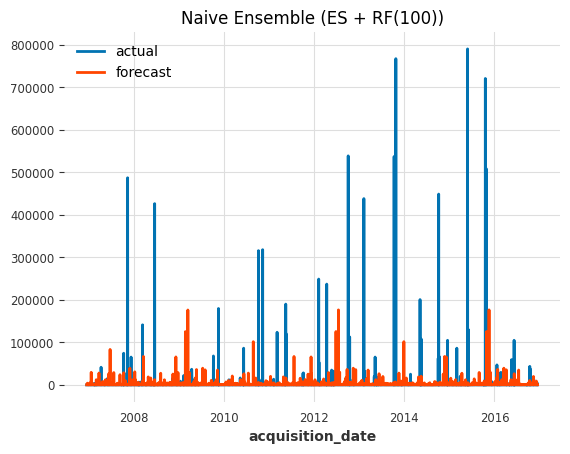

Successfully stored model [Naive Ensemble (ES + RF(200))] and its results.


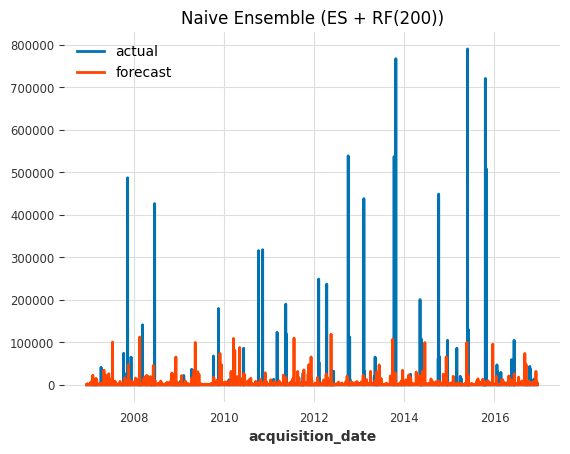

Successfully stored model [Naive Ensemble (ES + CatBoost(300))] and its results.


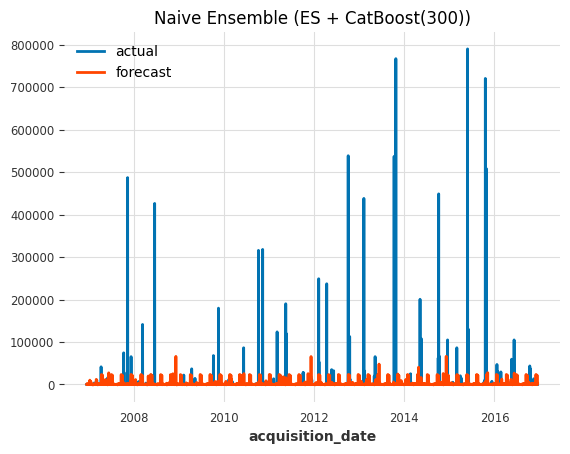

In [15]:
# Comparing Models for Selection
results = []
validation_data = ...
# How many periods to forecast out to
forecast_windows = [5, 10, 15, 20, 30, 50, 70, 100]

# Estimating forecasts using historical data
for model_name, model in models.items():
    # for window in forecast_windows:
    train, val = target_series.split_before(date_offset)
    train = fill_missing_values(train, 0.0)
    val = fill_missing_values(val, 0.0)
    validation_length = len(val)

    if model_name in ["Decision Tree", "Random Forest (10)", "Random Forest (50)", "Random Forest (100)", "Random Forest (200)", "CatBoost", "LightGBM", "Naive Ensemble (DT + RF(10))"]:
        model.fit(train, past_covariates = exogenous_series)

    else:
        model.fit(train)


    if model_name in ["Decision Tree", "Random Forest (10)", "Random Forest (50)", "Random Forest (100)", "Random Forest (200)", "CatBoost", "LightGBM", "Naive Ensemble (DT + RF(10))"]:
        predictions = model.predict(n = validation_length, past_covariates = exogenous_series)
    else:
        predictions = model.predict(n = validation_length)


    # Metrics selected for model selection
    mae = metrics.mae(val, predictions)
    rmse = np.sqrt(metrics.mse(val, predictions))
    ope = metrics.ope(val, predictions)
    
    # Calculate Coverage Probability (assuming a 95% prediction interval)
    pred_vals = predictions.values()
    val_vals = val.values()
    z_score = 1.96
    lower_bound = pred_vals - (z_score * np.std(pred_vals))
    upper_bound = pred_vals + (z_score * np.std(pred_vals))
    coverage_probability = np.mean((val_vals >= lower_bound) & (val_vals <= upper_bound))

    # Store all results
    model_results = defaultdict(int)
    validation_data = [val for sublist in val_vals for val in sublist]
    model_results["Model"] = model_name
    # model_results["Forecast Steps"].append(step_count)
    model_results["MAE"] = mae
    model_results["OPE"] = ope / 100
    model_results["RMSE"] = rmse
    model_results["Coverage Probability"] = coverage_probability
    model_results["Predictions"] = [pred for sublist in predictions.values() for pred in sublist]
    model_results["n-Predictions"] = len(predictions.values())
    results.append(model_results)
    print(f"Successfully stored model [{model_name}] and its results.")

    val.plot(label="actual")
    predictions.plot(label="forecast", color = "orangered")
    plt.title(model_name)
    plt.show()
    plt.close()

In [16]:
# Model performance visual comparisons
results = pd.DataFrame(results)
results = results.sort_values(
    by = ["Coverage Probability", "RMSE", "MAE",],
    ascending = [False, True, True]
)
results.head(10)

,Model,MAE,OPE,RMSE,Coverage Probability,Predictions,n-Predictions
10,Decision Tree,4094.347,0.523,41951.273,0.988,"[96.33333333333333, 0.0, 0.3333333333333333, 0...",3654
17,Naive Ensemble (DT + RF(10)),3855.459,0.604,37763.130,0.987,"[69.93333333333334, 8.45, 0.18333333333333332,...",3654
16,CatBoost,3700.467,0.696,35846.134,0.985,"[-31.525049327343027, 7297.301150445401, 255.2...",3654
14,Random Forest (200),3654.680,0.668,34796.842,0.984,"[881.9899841269842, 4316.037, 75.8572698412698...",3654
12,Random Forest (50),3572.301,0.700,34815.376,0.984,"[1350.1612698412698, 2158.8, 66.19841269841271...",3654
13,Random Forest (100),3633.866,0.676,35054.971,0.984,"[1019.2199682539682, 4314.514, 74.194539682539...",3654
11,Random Forest (10),3622.325,0.685,35073.459,0.983,"[43.53333333333333, 16.9, 0.03333333333333333,...",3654
22,Naive Ensemble (ES + RF(50)),4293.433,0.451,33801.923,0.966,"[330.5967396854461, 326.1654643283068, 326.200...",3654
23,Naive Ensemble (ES + RF(100)),4463.849,0.384,34006.726,0.965,"[330.3964539711604, 326.1654643283068, 326.200...",3654
6,Exponential Smoothing,3918.884,0.578,33314.168,0.964,"[652.5300507994637, 652.3309286566137, 652.381...",3654


In [17]:
results["Rank"] = results.groupby("Model")["RMSE"].rank(ascending = True)
top_10 = results[(results["Rank"] <= 10) & (results["Coverage Probability"] > 0.3)]
top_10["Model"] = top_10["Model"].apply(lambda x: x.replace("Random Forest ", "RF").replace("Naive Ensemble ", ""))

In [18]:
results.to_csv("ML_Model_Results.csv")
top_10.to_csv("ML_Model_Results-Top10.csv")
pd.Series(validation_data).to_csv("ML_Model_Validation_Data.csv")

In [30]:
# TODO: Remove visualization scaffolding
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.read_csv("ML_Model_Results.csv", index_col = 0)
top_10 = pd.read_csv("ML_Model_Results-Top10.csv", index_col = 0)
validation_data = pd.read_csv("ML_Model_Validation_Data.csv", index_col = 0)

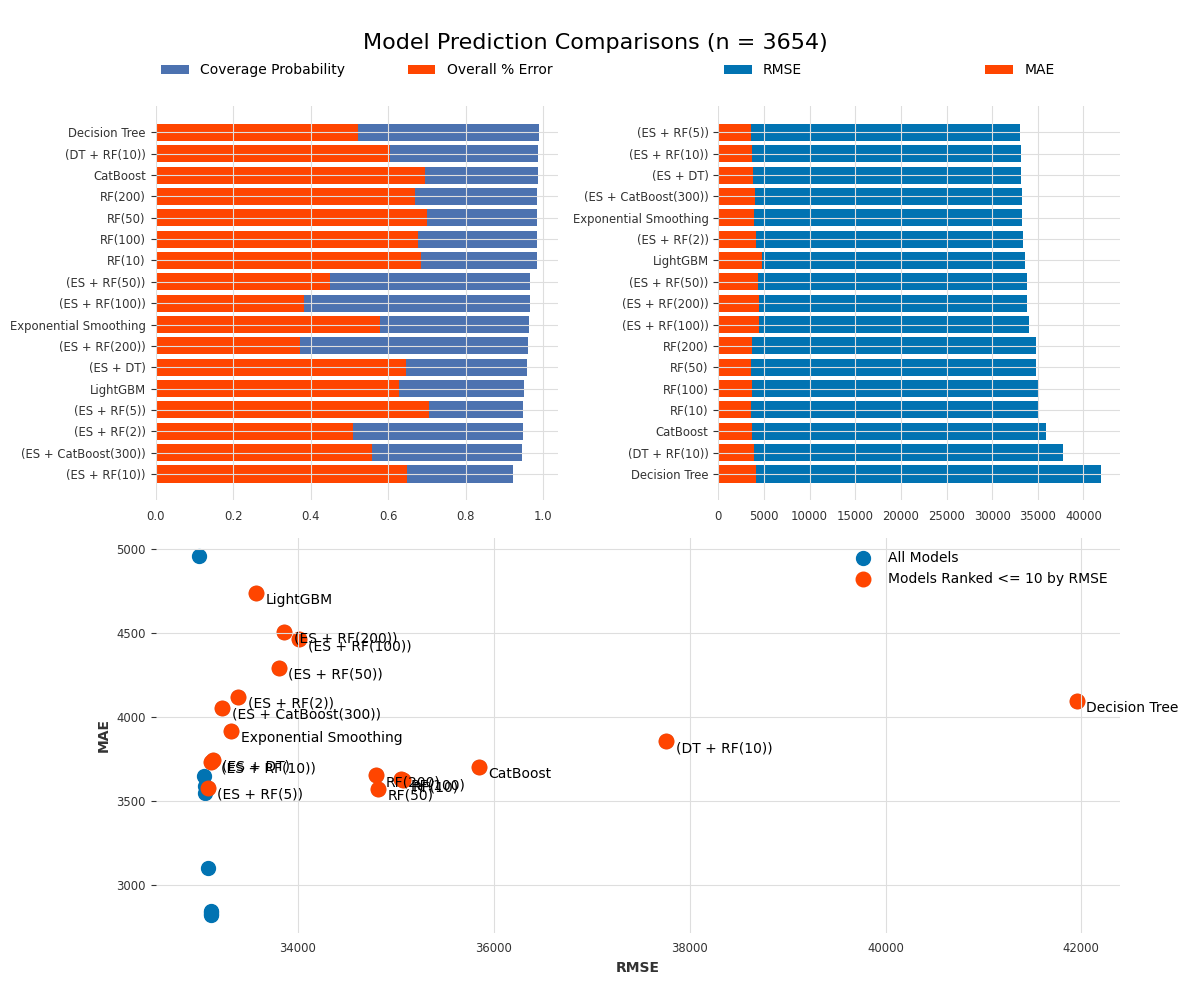

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plt.suptitle(f"\nModel Prediction Comparisons (n = {top_10['n-Predictions'].values[0]})", fontsize = 16)
top_10 = top_10.sort_values(["Coverage Probability", "OPE"])
axs[0, 0].barh(data = top_10, width = "Coverage Probability", y = "Model",
               color = sns.color_palette("deep")[0])
axs[0, 0].barh(data = top_10, width = "OPE", y = "Model",
               color="orangered")
axs[0, 0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc="upper left",
                 ncol=2, mode="expand", borderaxespad=0,
                 labels = ["Coverage Probability", "Overall % Error"])

# Plot 3:
# Not satisfied with histograms of ML Predictions yet, 
# too many predictions to plot Models (10) by each set of predictions (3654-long).
# also some values are negative, making it harder to plot.
# sns.histplot(data = top_10, x = "Predictions", hue = "Model", multiple = "stack", ax = axs[1, 1], log_scale = True)
# axs[1, 1].hist(validation_data, log = True, color = sns.color_palette("deep")[0])

top_10 = top_10.sort_values("RMSE", ascending = False)
axs[0, 1].barh(data = top_10, y = "Model", width = "RMSE")
axs[0, 1].barh(data = top_10, y = "Model", width = "MAE", color="orangered")
axs[0, 1].legend(bbox_to_anchor=(0., 1.02, 0.85, .102), loc="upper left",
           ncol=2, mode="expand", borderaxespad=0, labels = ["RMSE", "MAE"])

axs_bottom = fig.add_subplot(2, 1, 2)
axs_bottom.scatter(data = results, x = "RMSE", y = "MAE",
                   s = 100, norm = "log")
axs_bottom.scatter(data = top_10, x = "RMSE", y = "MAE",
                   s = 110, norm = "log", color = "orangered")
axs_bottom.legend(labels = ["All Models", "Models Ranked <= 10 by RMSE"])
axs_bottom.set_xlabel("RMSE")
axs_bottom.set_ylabel("MAE")
for index, row in top_10.iterrows():
    axs_bottom.text(row["RMSE"] + 100, row["MAE"], row["Model"], 
                    fontsize = 10, va="top", ha="left")

axs[1, 1].remove()
axs[1, 0].remove()

plt.tight_layout()
plt.show()
plt.close()

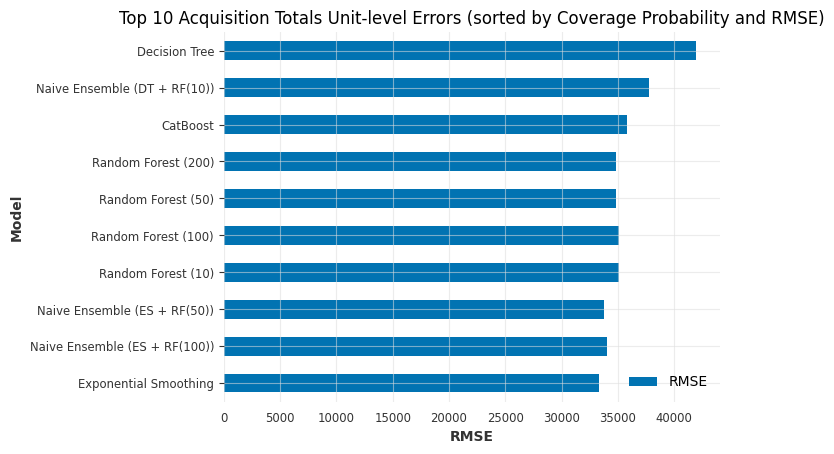

In [21]:
# Top 10 models with a Coverage Probability over 10%
# How to add Coverage Probability label onto bars?
(results[results["Coverage Probability"] >= 0.95]
 .sort_values(["Coverage Probability", "RMSE"], ascending = [False, True])
 .head(10)
 .plot
 .barh("Model", "RMSE")
 .set_xlabel("RMSE")
)
plt.title("Top 10 Acquisition Totals Unit-level Errors (sorted by Coverage Probability and RMSE)")
plt.grid(alpha = 0.55)
plt.gca().invert_yaxis()

In [22]:
# Create subplots (x, y)
# Subplot1: Model RMSE Ranks (w/ +95% Coverage Prob.) overlay MAE as another color.
# Subplot2: Coverage Probability %
# Subplot3: Distribution of original points
# Subplot4: Distributions of model predictions, colored by model name

In [23]:
# shap_explain = ShapExplainer(models["Decision Tree"])
# results = shap_explain.explain()
# shap_explain.summary_plot(plot_type = "violin")
# shap_explain.force_plot_from_ts()

In [24]:
# shap_explain = ShapExplainer(models["Random Forest"])
# results = shap_explain.explain()
# shap_explain.summary_plot(plot_type = "violin")
# shap_explain.force_plot_from_ts()

In [25]:
shap_explain = ShapExplainer(models["CatBoost"])
# expl_results = shap_explain.explain()

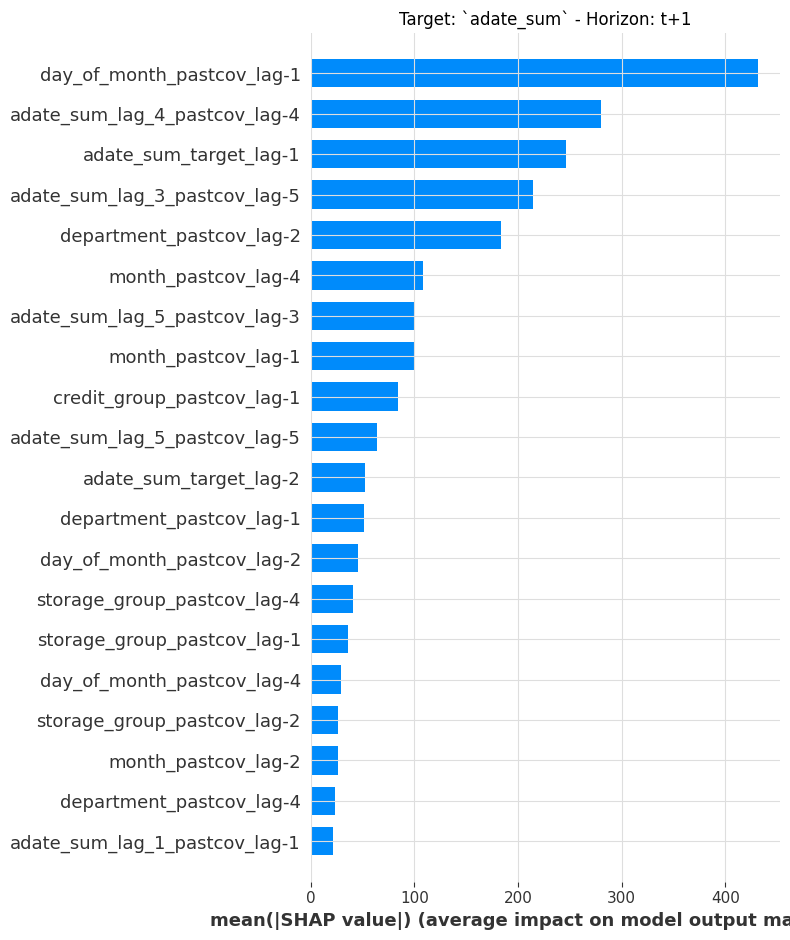

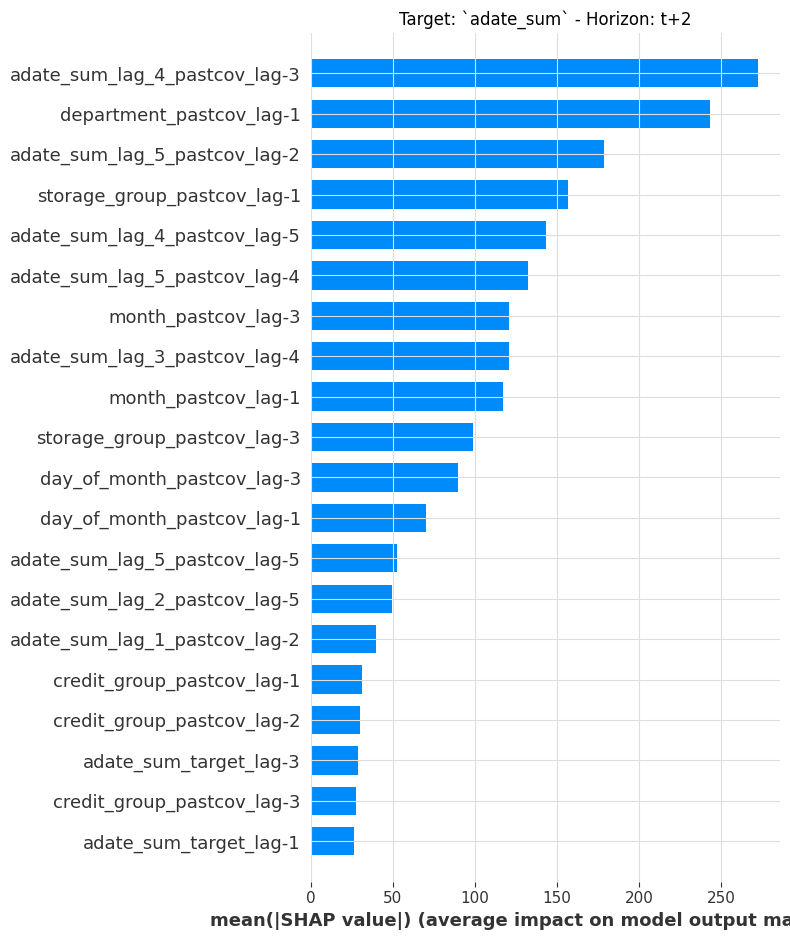

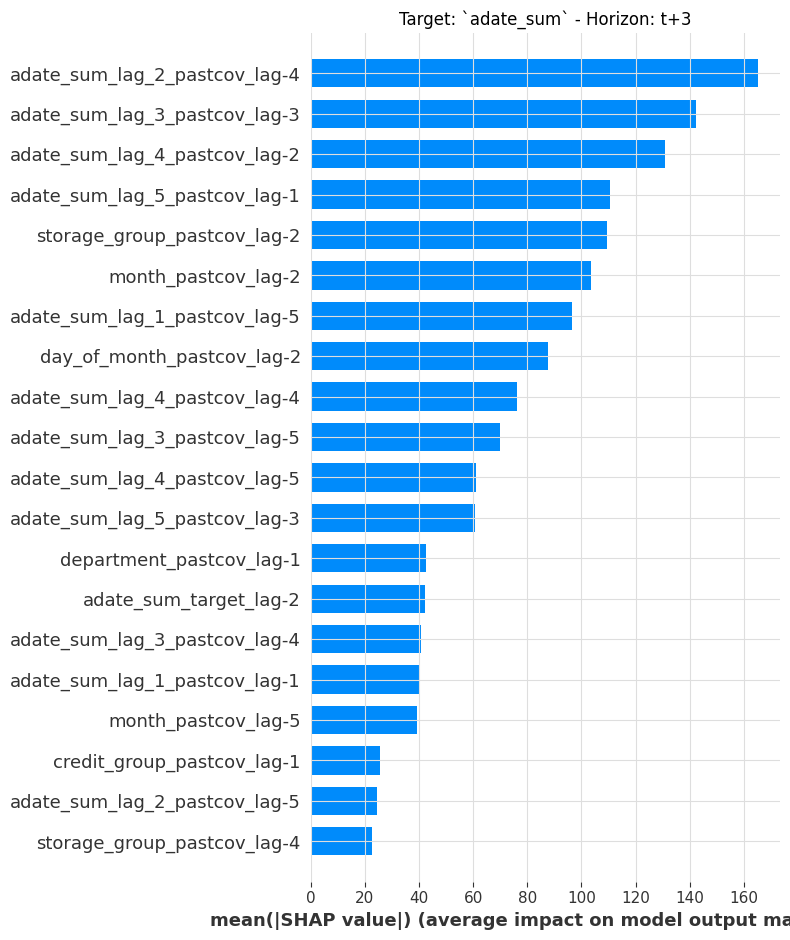

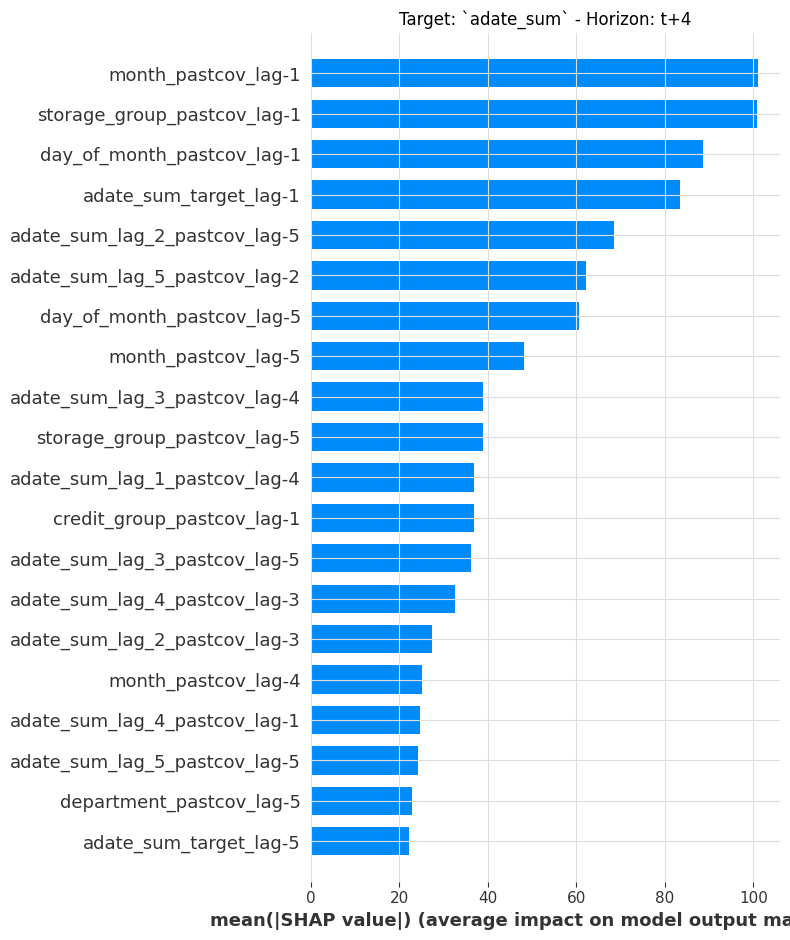

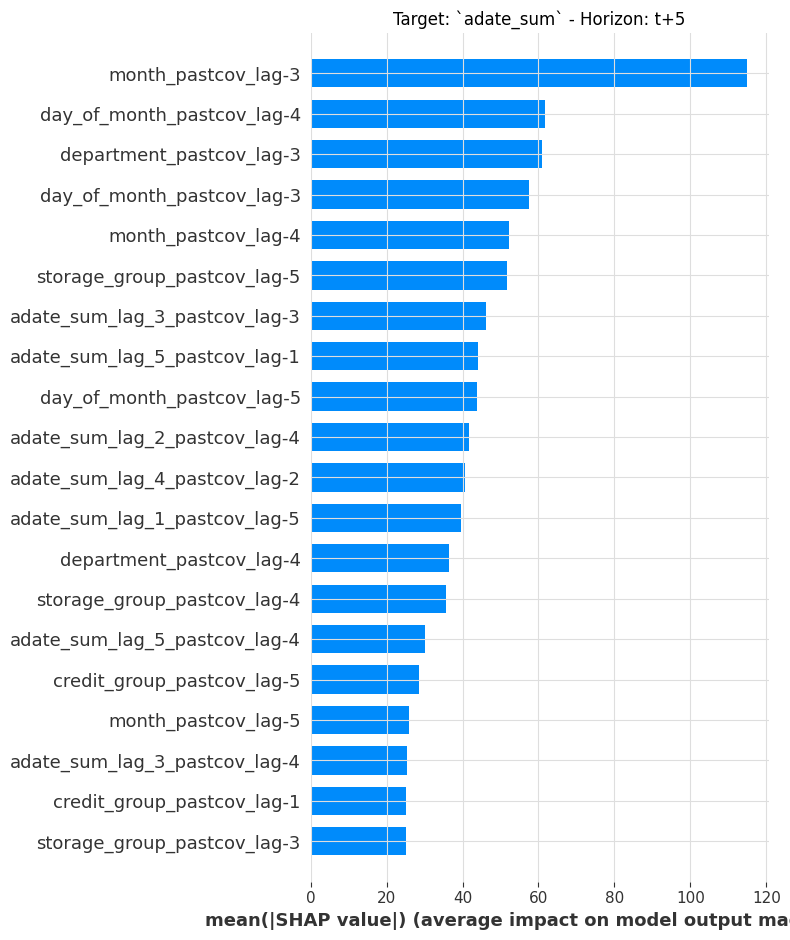

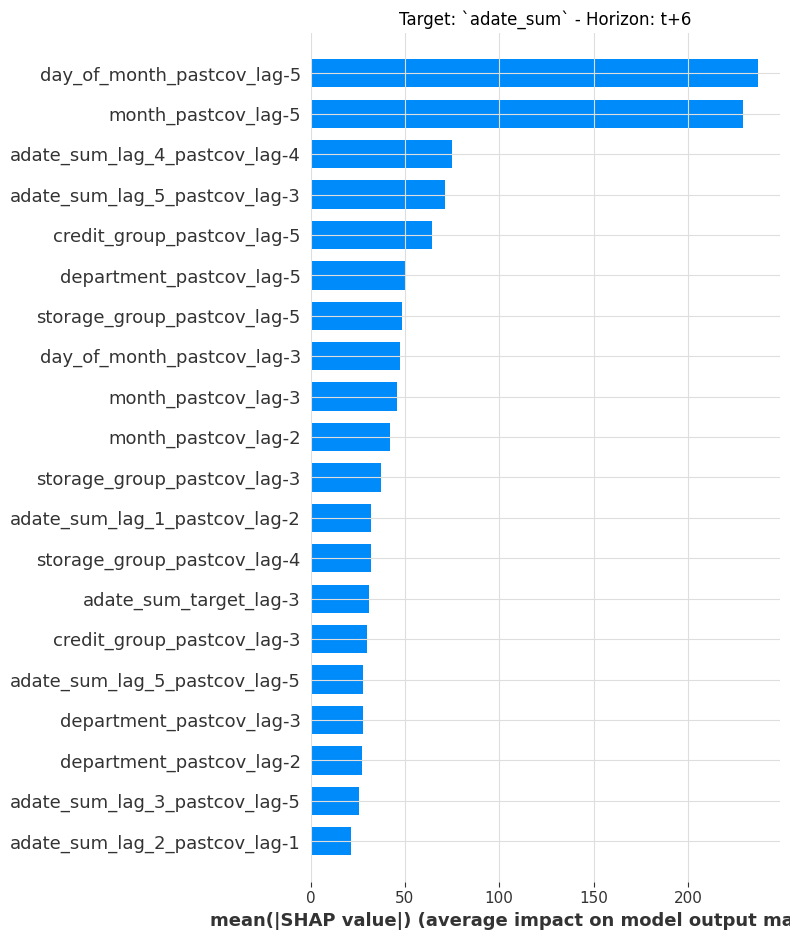

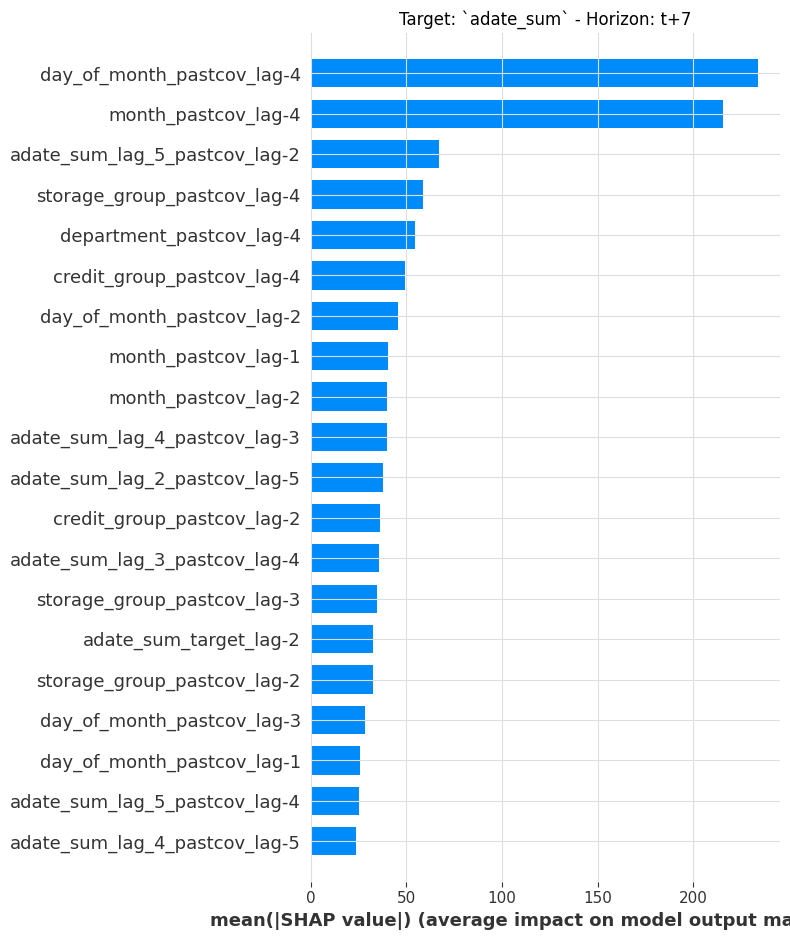

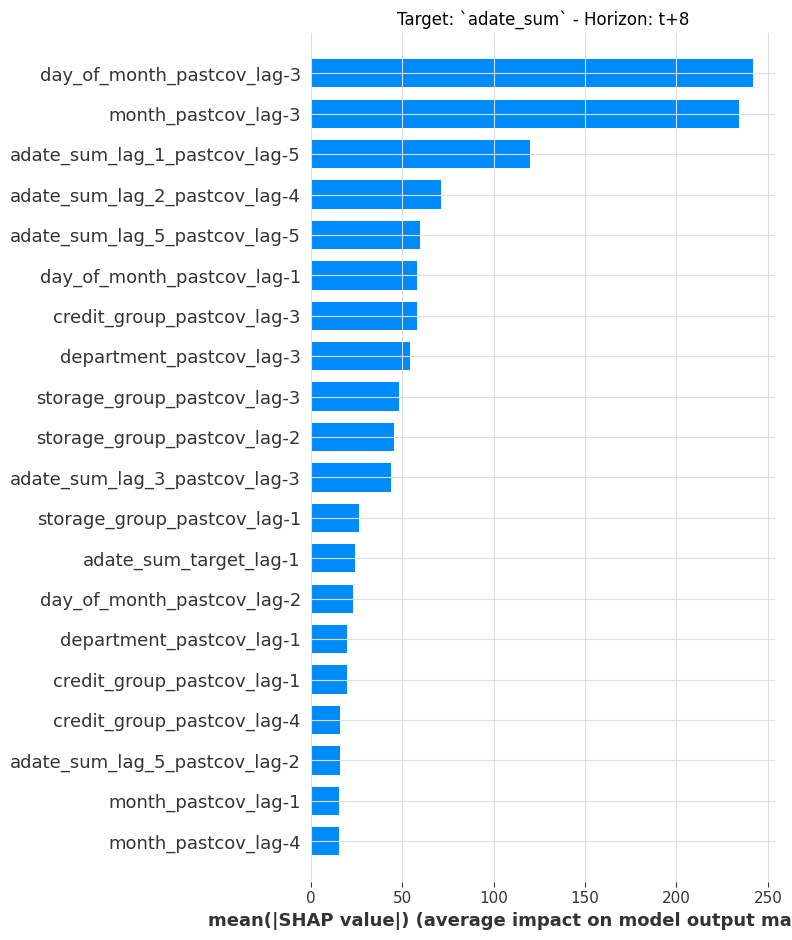

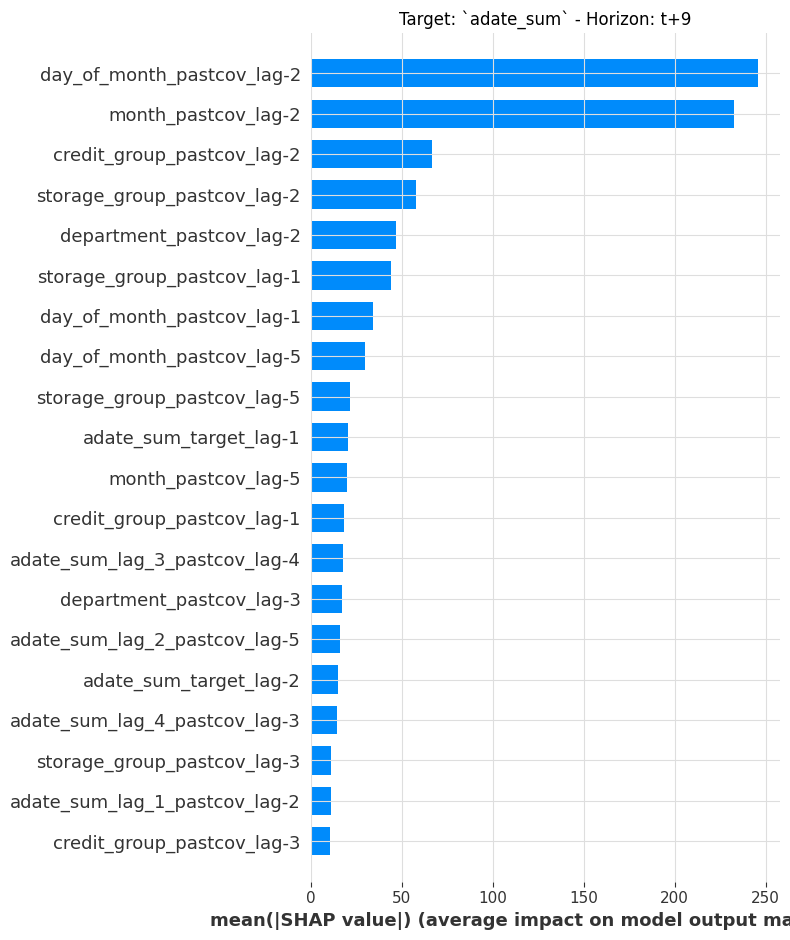

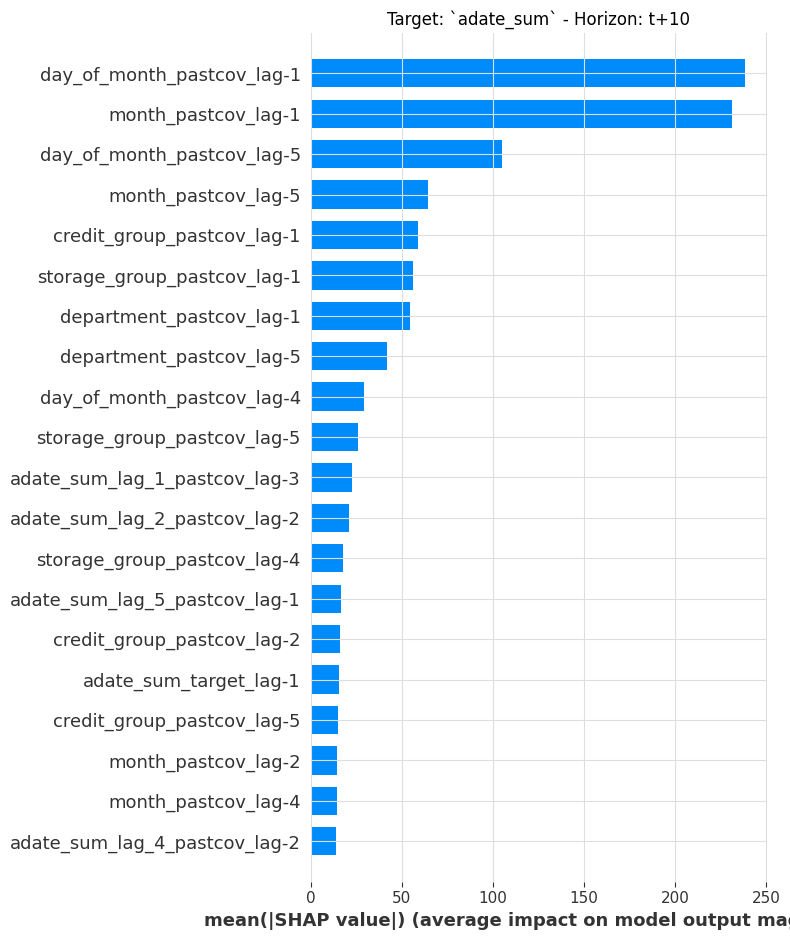

{1: {'adate_sum': .values =
  array([[ 1.71857878e+00,  3.70326127e+00, -2.75905451e-01, ...,
           1.91267472e+00,  8.96472073e-01, -1.49804723e+01],
         [ 1.97426853e+00,  7.06177181e+00, -2.75905451e-01, ...,
           4.75818295e+00,  2.04007138e+00,  1.39685350e+00],
         [ 1.95697034e+00,  6.77597450e+00,  5.49742489e+01, ...,
           4.75372793e+00,  2.04007138e+00,  1.39685350e+00],
         ...,
         [ 7.11679966e+00,  3.60795237e-01, -7.08024870e-01, ...,
           1.56304943e-01, -3.29458770e+01,  1.68561679e+00],
         [ 3.73096399e+00,  6.82101826e+00,  3.81732195e-02, ...,
           6.83483327e+00,  5.52081077e+00,  2.08431299e+00],
         [ 6.66519291e+00, -3.67473391e+00,  2.49154647e+01, ...,
          -2.93371462e+00,  4.09234031e+00,  1.35182927e+00]])
  
  .base_values =
  array([704.60576273, 704.60576273, 704.60576273, ..., 704.60576273,
         704.60576273, 704.60576273])
  
  .data =
  array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 

In [26]:
shap_explain.summary_plot(plot_type = "bar")
# shap_explain.force_plot_from_ts()


In [27]:
# Difficult for me to do effectively
# ref: https://stats.stackexchange.com/a/8782
# Alternative model, create a model of sales per period using pandas and numpy to preserve as much data as possible.
# Convert intake to intake-per-period: 
# intake-per-period = observed intake / (n-periods w/o intake)


Potential Future Features:
- [ ] Hierarchical Modeling (e.g. by Department, by Credit, etc.)
- [ ] Popular ML models (ARIMA, RandomForest, MCMC, etc.)
- [ ] With Multi-variate Models, we can have SHAP feature importance explanation.
- [ ] Calculating Backlog durations.

# We're about the process!
If streamlining means less people work, we want less of it. Data belong to the social.